# Cylinder Flow (Steady) DEMO code

This notebook demonstrates solving steady-state flow around a cylinder using Physics-Informed Neural Networks (PINNs).

In [2]:
import torch
a = torch.tensor([[1,2,3],[4,5,6]])
print(a[:, 1])

tensor([2, 5])


In [5]:
from deepflow import PINN, Geometry, Physics, NetworkTrainer, Evaluate, ProblemDomain

## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [ ]:
circle = Geometry.circle(0.2, 0.2, 0.05)
rectangle = Geometry.rectangle([0,1.1], [0,0.41])
area = rectangle - circle

C:\Users\thamm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


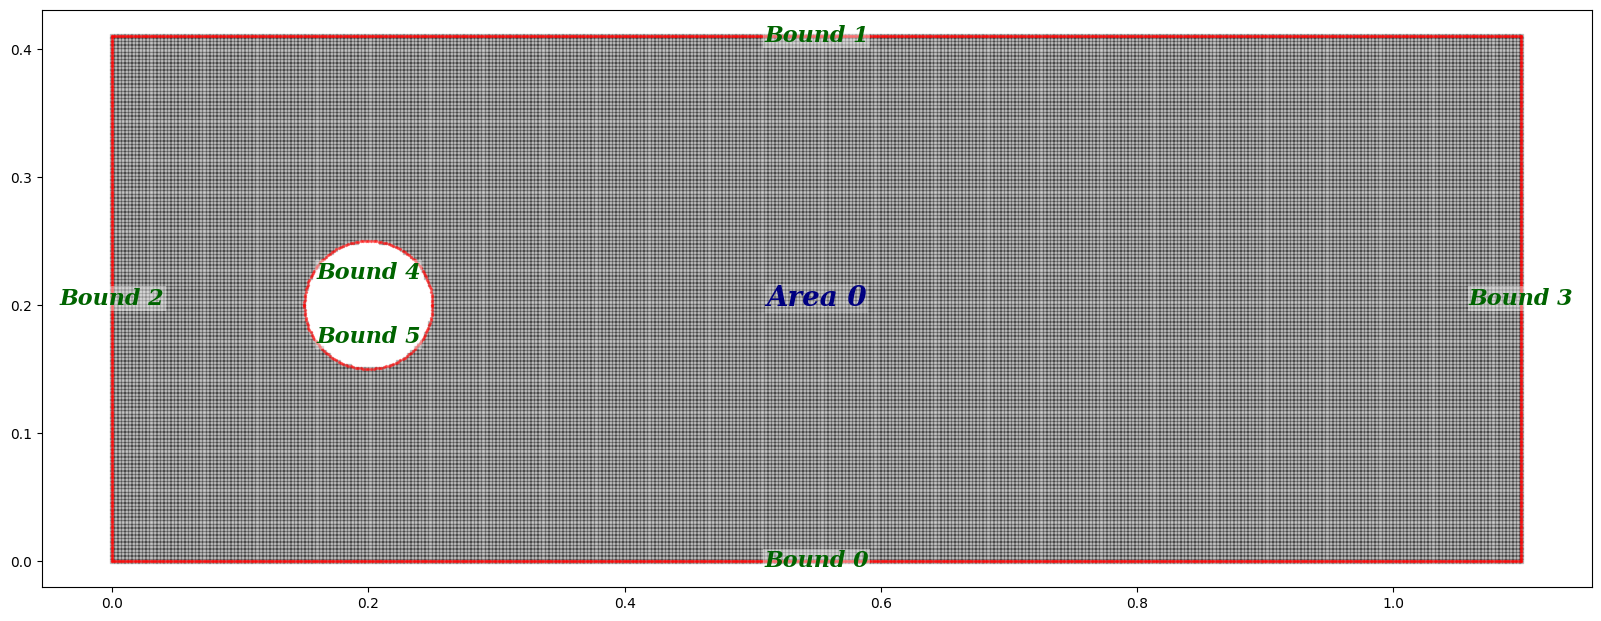

In [ ]:
domain = ProblemDomain(bound_list = rectangle.bound_list, area_list = [rectangle], device='cuda')
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

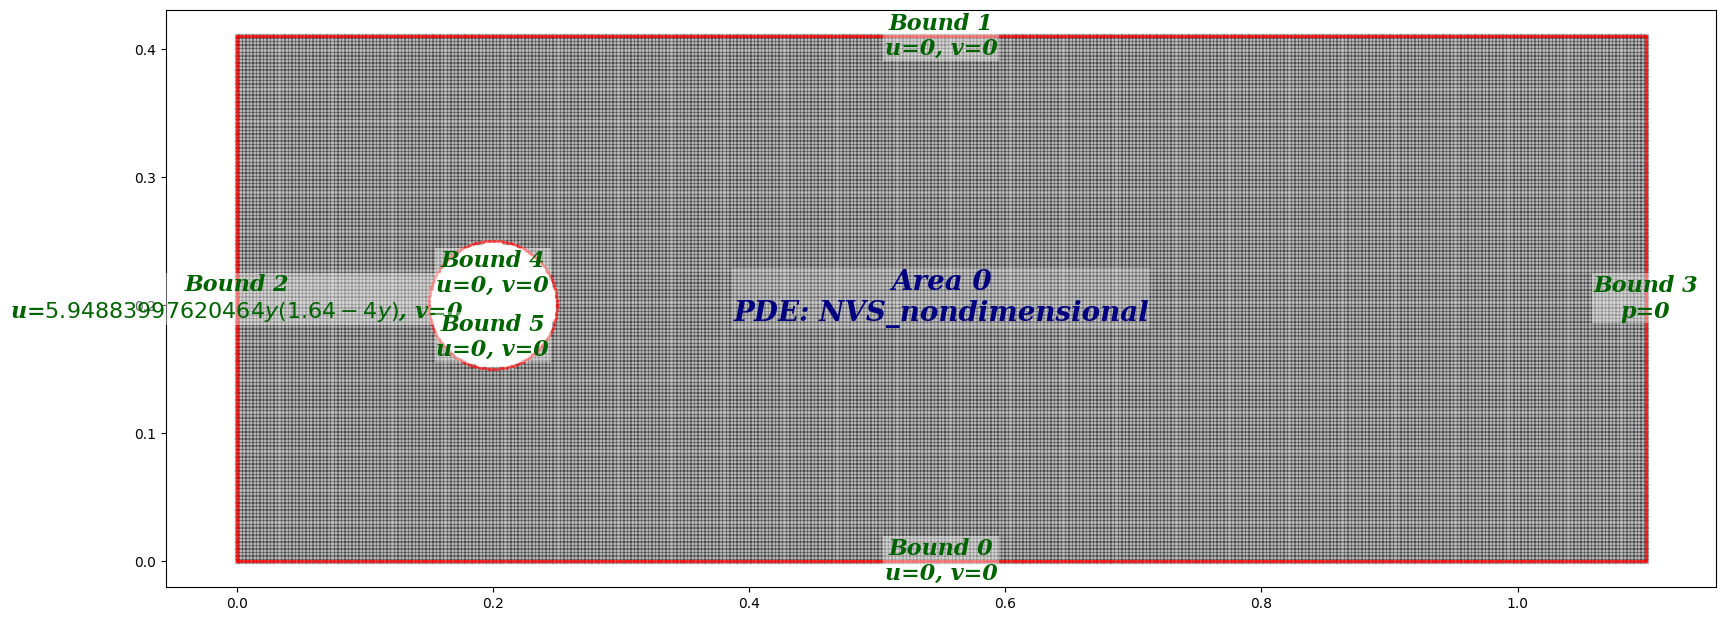

In [4]:
domain.bound_list[0].define_bc({'u':0,'v':0})
domain.bound_list[1].define_bc({'u':0,'v':0})
domain.bound_list[2].define_bc({'u': ['y', lambda x:  4*1*(0.41-x)*x/0.41**2], 'v': 0})
domain.bound_list[3].define_bc({'p':0})
domain.bound_list[4].define_bc({'u': 0, 'v': 0})
domain.bound_list[5].define_bc({'u': 0, 'v': 0})
domain.area_list[0].define_pde(Physics.NVS_nondimensional(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


Sample initial points for training. Required if using Residual-based Adaptive Refinement (RAR).

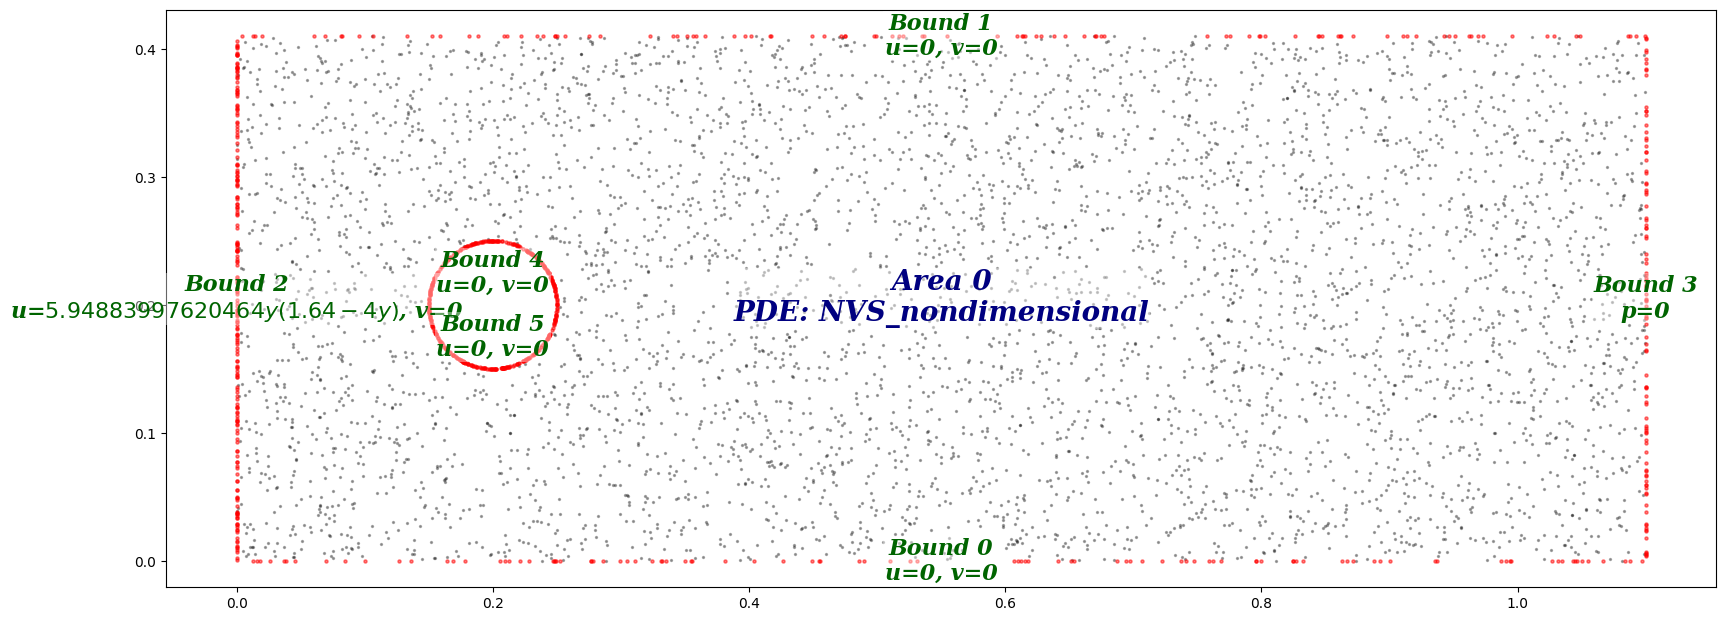

In [5]:
domain.sampling_random_r([100, 100, 200, 100, 200, 200], [5000])
domain.show_coordinates(display_conditions=True)

## 3. Train the PINN model
Initialize a PINN with specified width and depth.

In [6]:
model0 = PINN(width=40, length=8)

Design how to compute loss from boundary conditions and PDE residuals

In [ ]:
# Define the loss calculation function
N = 0
def calc_loss(model):
    global N
    N += 1

    # Add collocation points using RAR scheme
    if N % 1000==0:
        domain.sampling_RAR([40, 40, 160, 40, 80, 80], [2000], model, [200, 200, 400, 200, 400, 400], [20000]) #topk: 10% of candidate points
    
    # Resampling collocation points using Random-R scheme (less superior to RAR)
    # if N % 100 == 0:
    #     domain.sampling_random_r([100, 100, 200, 100, 200, 200], [5000], device='cuda')

    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        if i == 2: # if inlet bound
            bc_loss += 2*bc.calc_loss(model)
        else:
            bc_loss += bc.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = 3*bc_loss + pde_loss # weight bc_loss more

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss} # MUST RETURN IN THIS FORMAT

Train the model using Adam for initial training (faster convergence).

In [ ]:
# Train the model
model1 = NetworkTrainer.train_adam(
    model=model0,
    calc_loss=calc_loss,
    learning_rate=0.001,
    epochs=10000,
    print_every=250,
    threshold_loss=0.03,
    device='cuda'
)

epoch 1, total_loss: 3.36897, bc_loss: 1.12299, pde_loss: 0.00000
epoch 251, total_loss: 0.65865, bc_loss: 0.15284, pde_loss: 0.20013
epoch 501, total_loss: 0.49816, bc_loss: 0.10999, pde_loss: 0.16820
epoch 751, total_loss: 0.33809, bc_loss: 0.07609, pde_loss: 0.10984
epoch 1001, total_loss: 1.90535, bc_loss: 0.43671, pde_loss: 0.59521
epoch 1251, total_loss: 0.42314, bc_loss: 0.10475, pde_loss: 0.10890
epoch 1501, total_loss: 0.78454, bc_loss: 0.19178, pde_loss: 0.20919
epoch 1751, total_loss: 0.64448, bc_loss: 0.15351, pde_loss: 0.18394
epoch 2001, total_loss: 0.79958, bc_loss: 0.19237, pde_loss: 0.22248
epoch 2251, total_loss: 0.58110, bc_loss: 0.14528, pde_loss: 0.14527
epoch 2501, total_loss: 0.41365, bc_loss: 0.09472, pde_loss: 0.12948
epoch 2751, total_loss: 0.27459, bc_loss: 0.05432, pde_loss: 0.11163
epoch 3001, total_loss: 0.47045, bc_loss: 0.02487, pde_loss: 0.39585
epoch 3251, total_loss: 0.15373, bc_loss: 0.02610, pde_loss: 0.07542
epoch 3501, total_loss: 0.11639, bc_loss

Refine the model using LBFGS for higher precision.

In [ ]:
# Train the model
model2 = NetworkTrainer.train_lbfgs(
    model=model1,
    calc_loss=calc_loss,
    epochs=500,
    print_every=50,
    threshold_loss=0.002,
    device='cuda'
)

epoch 6407, total_loss: 0.02826, bc_loss: 0.00323, pde_loss: 0.01855
epoch 6457, total_loss: 0.01056, bc_loss: 0.00091, pde_loss: 0.00784
epoch 6507, total_loss: 0.00689, bc_loss: 0.00079, pde_loss: 0.00454
epoch 6557, total_loss: 0.00529, bc_loss: 0.00067, pde_loss: 0.00329
epoch 6607, total_loss: 0.00381, bc_loss: 0.00051, pde_loss: 0.00229
epoch 6657, total_loss: 0.00324, bc_loss: 0.00042, pde_loss: 0.00197
epoch 6707, total_loss: 0.00252, bc_loss: 0.00033, pde_loss: 0.00153
epoch 6757, total_loss: 0.00225, bc_loss: 0.00031, pde_loss: 0.00133
Training stopped at epoch 382 as total loss reached the threshold of 0.002.


Save or Load the model for later use

In [2]:
import pickle
# # Save model with pickle
# with open("model2.pkl", "wb") as f:
#     pickle.dump(model2, f)

# Load model back
with open("model2.pkl", "rb") as f:
    model2 = pickle.load(f)

Show the final sampled points used in training

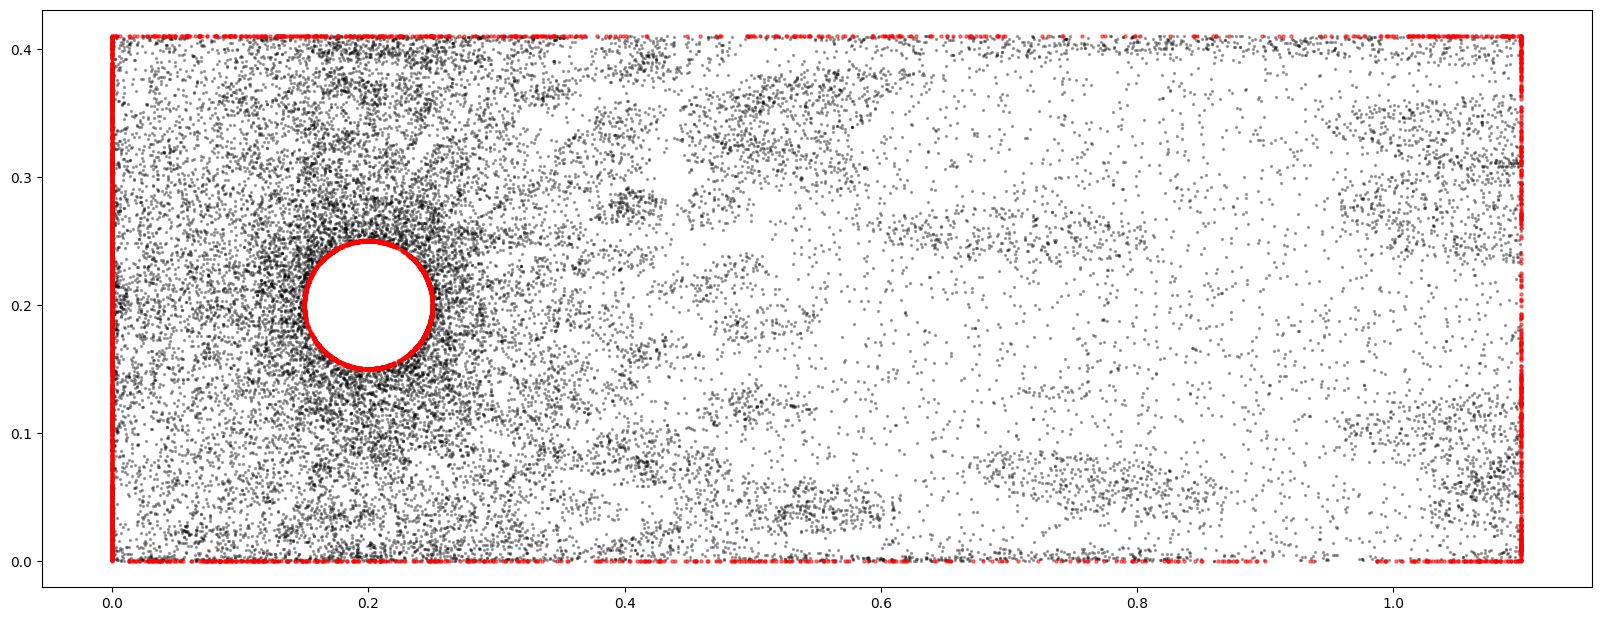

number of bound : 6
        ['0: 500', '1: 500', '2: 1800', '3: 500', '4: 1000', '5: 1000']
        , number of area : 1
        ['0: 24908']


In [12]:
domain.show_coordinates()
print(domain)

## 4. Visualization

### 4.1 Visualize area

In [ ]:
# Create object for evaluation (Need Model and Geometry)
area_visual = Evaluate(model2, domain.area_list[0])
# Sampling uniform points
area_visual.sampling_area(700, 300)

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


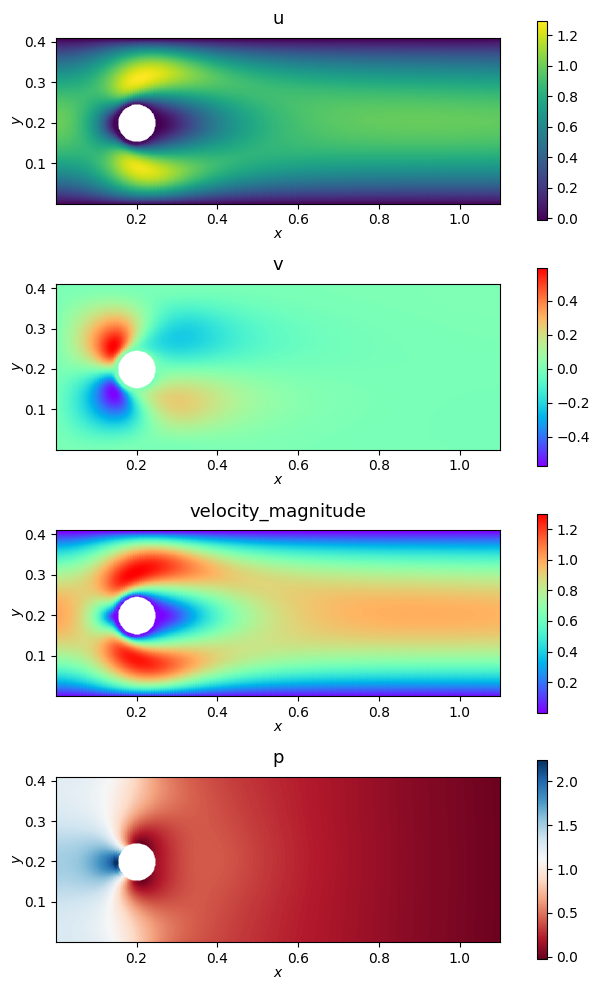

In [15]:
cmap_dict = {
    'u':None,
    'v':'rainbow',
    'velocity_magnitude': 'rainbow',
    'p':'RdBu',
}
colorplot_area_2d = area_visual.plot_data_on_geometry(cmap_dict, s=1)
colorplot_area_2d.savefig('colorplot_area_2d.png')

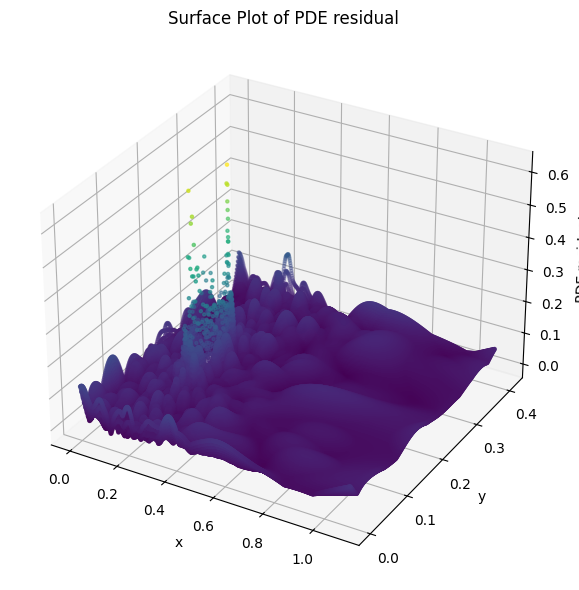

In [16]:
residual_plot_3d = area_visual.plot_data('PDE residual')
residual_plot_3d.savefig('residual_plot_3d.png')

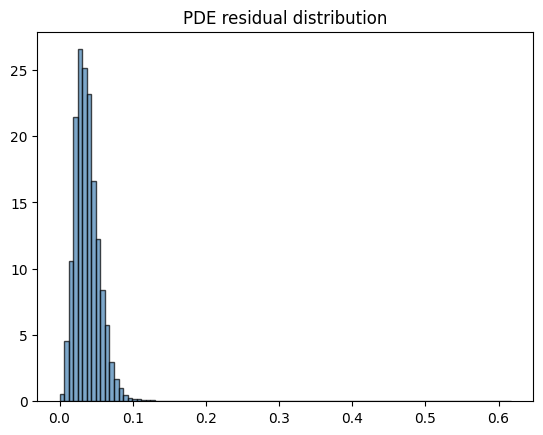

In [17]:
residual_destribution = area_visual.plot_data_distribution('PDE residual', bins=100)

### 4.2 Visualize bound

In [ ]:
# Create object for evaluation (Need Model and Geometry)
bound_visual = Evaluate(model2, domain.bound_list[3])
# Sampling uniform points
bound_visual.sampling_line(100)

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


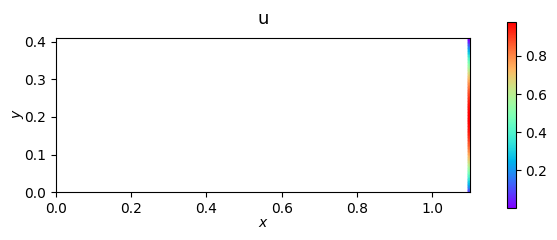

In [ ]:
cmap_dict = {'u':'rainbow','BC residual':None}
colorplot_bound = bound_visual.plot_data_on_geometry(cmap_dict, range_x=[0,1.1], range_y=[0,0.41], s=20)
colorplot_bound.savefig('colorplot_bound.png')

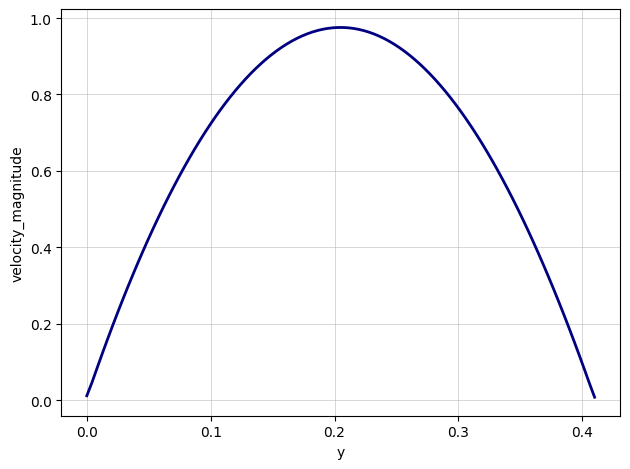

In [20]:
velocity_plot_outlet = bound_visual.plot_data({'velocity_magnitude':'viridis'}, axis='y')
velocity_plot_outlet.savefig('velocity_plot_outlet.png')

## 4.3 Visualize Neural Network data

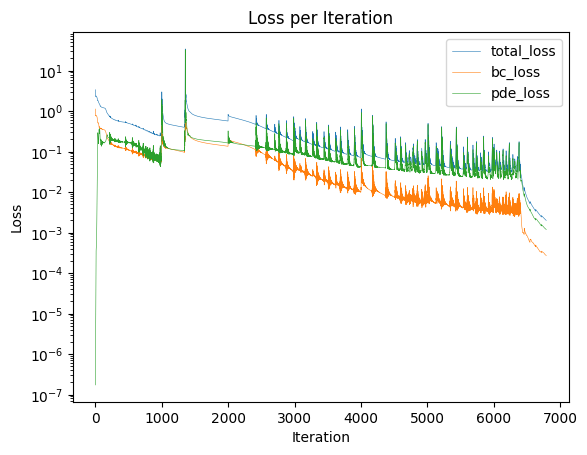

In [21]:
loss_history = bound_visual.plot_loss_curve(log_scale=True, linewidth=0.4)
loss_history.savefig('loss_history.png')

### 4.4 Export data

In [23]:
# display available options
print(bound_visual.data_dict.keys())

dict_keys(['u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss'])


In [24]:
# store the x,y,velocity_magnitude data
x_data = bound_visual.data_dict['x']
y_data = bound_visual.data_dict['y']
velocity_magnitude_data = bound_visual.data_dict['velocity_magnitude']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, velocity_magnitude_data))
np.savetxt('outlet_velocity_profile.txt', array)